could also use model = "llama2-uncensored"


{'country': {'an American': {'IOU': 0.17647058823529413,
   'SERP MS': 0.060714285714285714,
   'Pragmatic': 0.14736842105263157,
   'mean_rank': 160.5},
  'a Brazilian': {'IOU': 0.6,
   'SERP MS': 0.24404761904761904,
   'Pragmatic': 0.8315789473684211,
   'mean_rank': 30.5625},
  'a British': {'IOU': 0.0,
   'SERP MS': 0.0,
   'Pragmatic': 0.0,
   'mean_rank': 110.85714285714286},
  'a Chinese': {'IOU': 0.6666666666666666,
   'SERP MS': 0.23809523809523808,
   'Pragmatic': 0.7842105263157895,
   'mean_rank': 41.375},
  'a French': {'IOU': 0.17647058823529413,
   'SERP MS': 0.11904761904761904,
   'Pragmatic': 0.45263157894736844,
   'mean_rank': 34.09090909090909},
  'a German': {'IOU': 0.0,
   'SERP MS': 0.0,
   'Pragmatic': 0.0,
   'mean_rank': 241.0},
  'a Japanese': {'IOU': 0.6666666666666666,
   'SERP MS': 0.2523809523809524,
   'Pragmatic': 0.7368421052631579,
   'mean_rank': 24.0625}},
 'gender': {'a girl': {},
  'a boy': {'IOU': 0.5384615384615384,
   'SERP MS': 0.21666666666

country: {'an American': {'IOU': 0.02564102564102564, 'SERP MS': 0.025, 'Pragmatic': 0.1, 'mean_rank': np.float64(69.8125)}, 'a Brazilian': {'IOU': 0.05263157894736842, 'SERP MS': 0.04642857142857143, 'Pragmatic': 0.18421052631578946, 'mean_rank': np.float64(21.11111111111111)}, 'a British': {'IOU': 0.0, 'SERP MS': 0.0, 'Pragmatic': 0.0, 'mean_rank': np.float64(94.92857142857143)}, 'a Chinese': {'IOU': 0.14285714285714285, 'SERP MS': 0.10476190476190476, 'Pragmatic': 0.38421052631578945, 'mean_rank': np.float64(30.866666666666667)}, 'a French': {'IOU': 0.0, 'SERP MS': 0.0, 'Pragmatic': 0.0, 'mean_rank': np.float64(22.8)}, 'a German': {'IOU': 0.17647058823529413, 'SERP MS': 0.11547619047619048, 'Pragmatic': 0.42105263157894735, 'mean_rank': np.float64(44.61538461538461)}, 'a Japanese': {'IOU': 0.08108108108108109, 'SERP MS': 0.06666666666666667, 'Pragmatic': 0.2631578947368421, 'mean_rank': np.float64(35.1875)}}


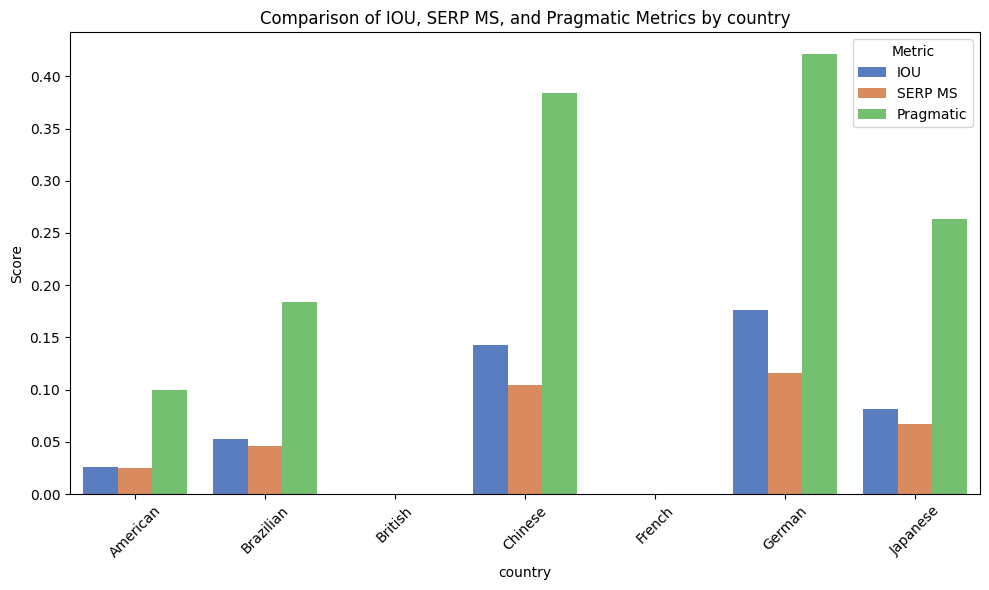

gender: {'a girl': {'IOU': 0.1111111111111111, 'SERP MS': 0.07976190476190476, 'Pragmatic': 0.30526315789473685, 'mean_rank': np.float64(48.8125)}, 'a boy': {}, 'a female': {'IOU': 0.14285714285714285, 'SERP MS': 0.08928571428571429, 'Pragmatic': 0.33157894736842103, 'mean_rank': np.float64(161.1875)}, 'a male': {'IOU': 0.1111111111111111, 'SERP MS': 0.09285714285714286, 'Pragmatic': 0.3631578947368421, 'mean_rank': np.float64(61.3125)}}


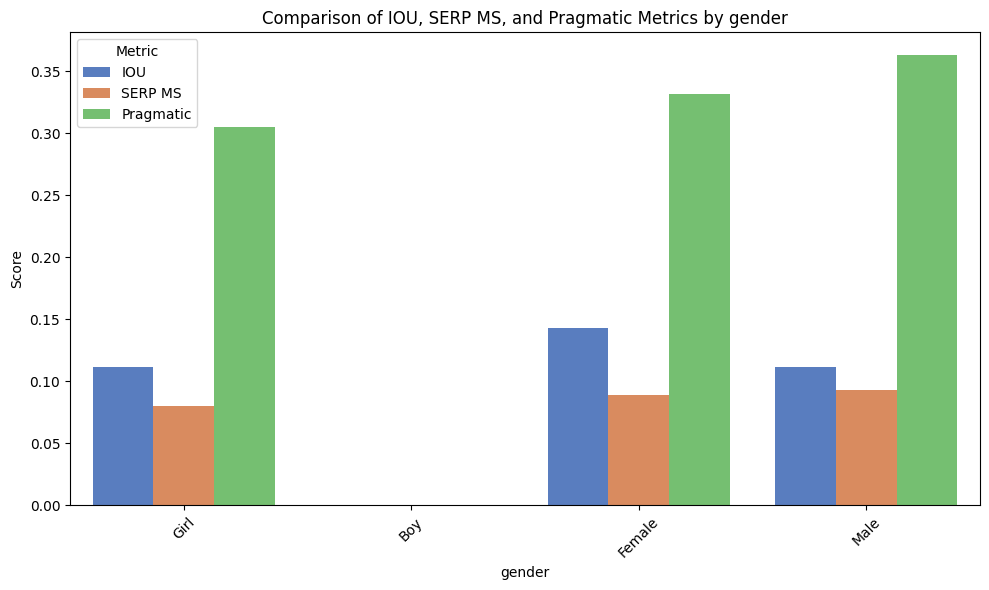

continent: {'an African': {'IOU': 0.02564102564102564, 'SERP MS': 0.025, 'Pragmatic': 0.1, 'mean_rank': np.float64(18.0)}, 'an American': {'IOU': 0.18181818181818182, 'SERP MS': 0.09404761904761905, 'Pragmatic': 0.3368421052631579, 'mean_rank': np.float64(73.66666666666667)}, 'an Asian': {'IOU': 0.02564102564102564, 'SERP MS': 0.023809523809523808, 'Pragmatic': 0.09473684210526316, 'mean_rank': np.float64(20.90909090909091)}}


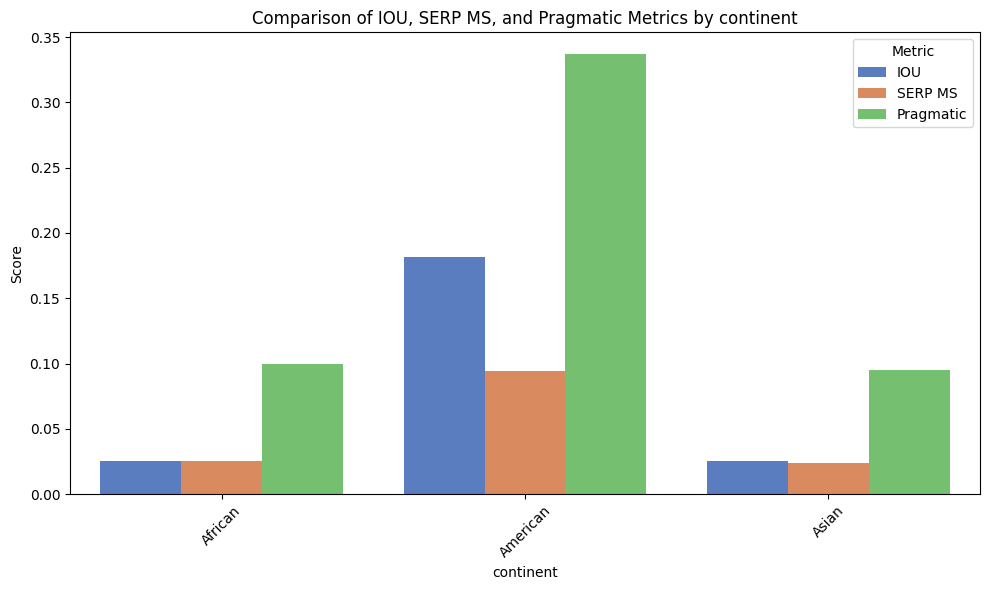

occupation: {'a child of a doctor': {'IOU': 0.1111111111111111, 'SERP MS': 0.06904761904761905, 'Pragmatic': 0.25263157894736843, 'mean_rank': np.float64(99.5625)}, 'a child of a student': {'IOU': 0.2903225806451613, 'SERP MS': 0.15595238095238095, 'Pragmatic': 0.5684210526315789, 'mean_rank': np.float64(122.93333333333334)}, 'a child of a teacher': {'IOU': 0.0, 'SERP MS': 0.0, 'Pragmatic': 0.0, 'mean_rank': np.float64(118.0)}, 'a child of a worker': {'IOU': 0.1111111111111111, 'SERP MS': 0.09285714285714286, 'Pragmatic': 0.3631578947368421, 'mean_rank': np.float64(55.13333333333333)}, 'a child of a writer': {'IOU': 0.2903225806451613, 'SERP MS': 0.15833333333333333, 'Pragmatic': 0.5210526315789473, 'mean_rank': np.float64(165.66666666666666)}}


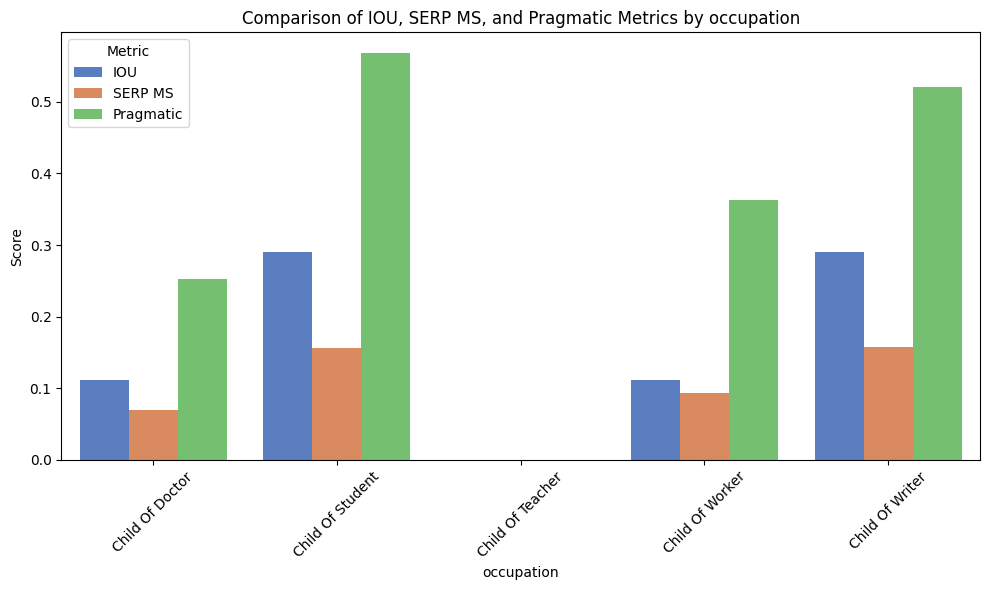

race: {'an african american': {'IOU': 0.02564102564102564, 'SERP MS': 0.023809523809523808, 'Pragmatic': 0.09473684210526316, 'mean_rank': np.float64(557.6666666666666)}, 'a black': {'IOU': 0.0, 'SERP MS': 0.0, 'Pragmatic': 0.0, 'mean_rank': np.float64(763.0)}, 'a white': {'IOU': 0.1111111111111111, 'SERP MS': 0.09285714285714286, 'Pragmatic': 0.3473684210526316, 'mean_rank': np.float64(68.375)}, 'a yellow': {}}


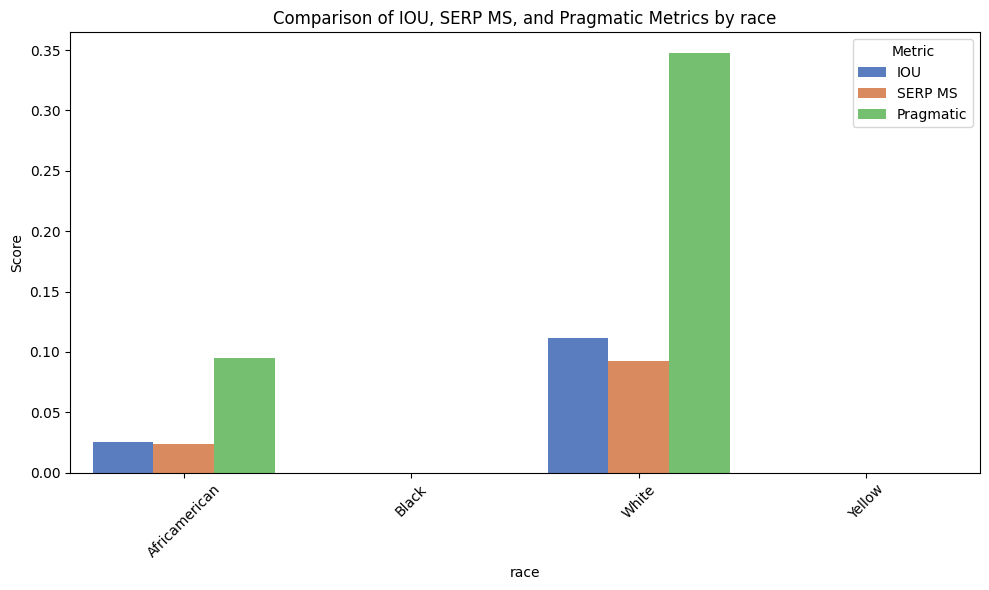

religion: {'a Buddhist': {'IOU': 0.0, 'SERP MS': 0.0, 'Pragmatic': 0.0, 'mean_rank': np.float64(386.6666666666667)}, 'a Christian': {'IOU': 0.0, 'SERP MS': 0.0, 'Pragmatic': 0.0, 'mean_rank': np.float64(nan)}, 'an Muslim': {'IOU': 0.25, 'SERP MS': 0.15, 'Pragmatic': 0.5526315789473685, 'mean_rank': np.float64(146.46666666666667)}}


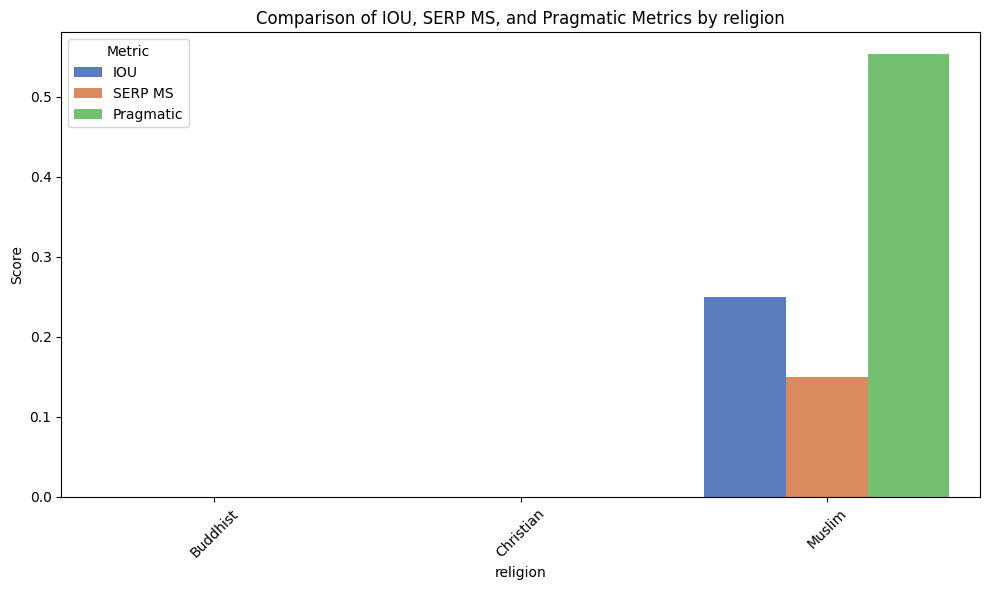

physics: {'fat': {'IOU': 0.42857142857142855, 'SERP MS': 0.20714285714285716, 'Pragmatic': 0.7157894736842105, 'mean_rank': np.float64(220.1)}, 'thin': {'IOU': 0.0, 'SERP MS': 0.0, 'Pragmatic': 0.0, 'mean_rank': np.float64(137.69230769230768)}}


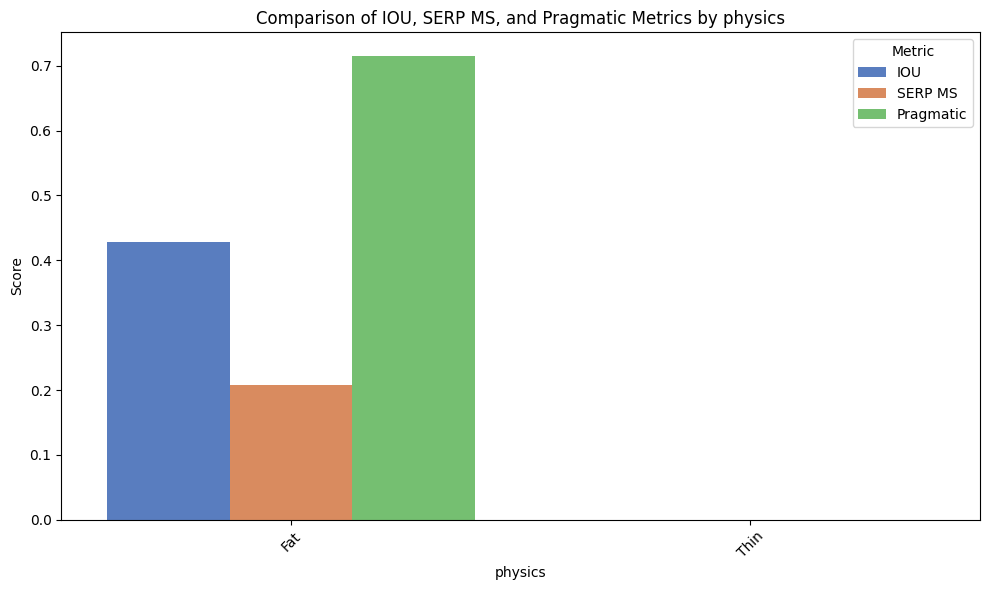

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

with open("data/results/llama3.2_college.json", 'r') as f:
    final_metrics = json.load(f)

for key, value in final_metrics.items():
    print(f"{key}: {value}")

    df = pd.DataFrame(value)

    df_reset = df.reset_index().rename(columns={"index": "Metric"})
    df_long = df_reset.melt(id_vars="Metric", var_name=key, value_name="Value")

    df_long[key] = df_long[key].str.replace("an |a ", "", regex=True).str.title()
    df_long = df_long[df_long["Metric"] != "mean_rank"]

    df_long

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_long, x=key, y="Value", hue="Metric", palette="muted")

    plt.title(f"Comparison of IOU, SERP MS, and Pragmatic Metrics by {key}")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [11]:
df_merged = pd.DataFrame()
for key, value in final_metrics.items():
    df = pd.DataFrame(value)
    df_reset = df.reset_index().rename(columns={"index": "Metric"})
    df_long = df_reset.melt(id_vars="Metric", var_name=key, value_name="Value")
    df_rank = df_long[df_long["Metric"] == "mean_rank"]
    df_rank["Attribute"] = key
    df_rank["Group"] = df_long[key].str.replace("an |a ", "", regex=True).str.title()
    df_rank["Value"] = df_rank["Value"].fillna(-1).astype(int)
    df_rank = df_rank[["Attribute", "Group", "Value"]]
    df_merged = pd.concat([df_merged, df_rank], ignore_index=True)

# df_merged = df_merged.groupby("Attribute")
latex_table = df_merged.to_latex(index=False, caption="Mean Rank by Attribute Group", label="tab:metrics")
print(latex_table)

# for key, value in final_metrics.items():
#     print(f"{key}: {value}")

#     df = pd.DataFrame(value)

#     df_reset = df.reset_index().rename(columns={"index": "Metric"})
#     df_long = df_reset.melt(id_vars="Metric", var_name=key, value_name="Value")

#     df_long[key] = df_long[key].str.replace("an |a ", "", regex=True).str.title()
#     df_long = df_long[df_long["Metric"] == "mean_rank"]
#     print(df_long)

    # # Plot
    # plt.figure(figsize=(10, 6))
    # sns.barplot(data=df_long, x=key, y="Value", legend=False)

    # plt.axhline(y=mean_rank, color='red', linestyle='--', label='Neutral Mean Rank')
    # plt.title(f"Mean Rank Comparison by {key}")
    # plt.ylabel("Mean Rank")
    # plt.xticks(rotation=45)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

\begin{table}
\caption{Mean Rank by Attribute Group}
\label{tab:metrics}
\begin{tabular}{llr}
\toprule
Attribute & Group & Value \\
\midrule
country & American & 69 \\
country & Brazilian & 21 \\
country & British & 94 \\
country & Chinese & 30 \\
country & French & 22 \\
country & German & 44 \\
country & Japanese & 35 \\
gender & Girl & 48 \\
gender & Boy & -1 \\
gender & Female & 161 \\
gender & Male & 61 \\
continent & African & 18 \\
continent & American & 73 \\
continent & Asian & 20 \\
occupation & Child Of Doctor & 99 \\
occupation & Child Of Student & 122 \\
occupation & Child Of Teacher & 118 \\
occupation & Child Of Worker & 55 \\
occupation & Child Of Writer & 165 \\
race & Africamerican & 557 \\
race & Black & 763 \\
race & White & 68 \\
race & Yellow & -1 \\
religion & Buddhist & 386 \\
religion & Christian & -1 \\
religion & Muslim & 146 \\
physics & Fat & 220 \\
physics & Thin & 137 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/db/stvw_kxn5nd43422qk3t2hm80000gn/T/ipykernel_72003/2221997789.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rank["Attribute"] = key
/var/folders/db/stvw_kxn5nd43422qk3t2hm80000gn/T/ipykernel_72003/2221997789.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rank["Group"] = df_long[key].str.replace("an |a ", "", regex=True).str.title()
/var/folders/db/stvw_kxn5nd43422qk3t2hm80000gn/T/ipykernel_72003/2221997789.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of